# Investigate required values

Investigate which values are needed to predict in order to fully specify a protein correctly

In [2]:
import os, sys
import functools
import itertools
import multiprocessing
import warnings
import importlib
import tempfile
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol
import nglview as nv

import torch

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), "protdiff")
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import datasets
import angles_and_coords as ac
import nerf
import tmalign  # So we can compare structural similarity
import plotting

datasets.LOCAL_DATA_DIR

PosixPath('/home/wukevin/projects/protdiff/data')

In [8]:
importlib.reload(datasets)

train_dset = datasets.CathCanonicalAnglesOnlyDataset(
    split='train',
    zero_center=True,
)
len(train_dset.filenames)

24316

In [38]:
train_dset_noised = datasets.NoisedAnglesDataset(
    train_dset,
    timesteps=1000,
)
str(train_dset_noised)

'NoisedAnglesDataset wrapping <datasets.CathCanonicalAnglesOnlyDataset object at 0x7f22af2a25e0> with 24316 examples with linear-1000 with variance scales 1.0 and 1.0'

In [35]:
def view_pdb_py3dmol(fname:str):
    """
    View a PDB file in a Jupyter notebook
    See: https://william-dawson.github.io/using-py3dmol.html
    """
    with open(fname) as source:
        system = "".join([l for l in source])
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(system)
    # view.setStyle({'chain': -1}, {"cartoon": {'color': 'blue'}})
    # view.setStyle({"model": -1}, {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.setStyle({"cartoon": {"color":"blue"}})
    view.zoomTo()
    view.show()

def view_pdb(fname:str, save_to:str=""):
    """View the PDB file"""
    view = nv.show_file(str(fname))
    if save_to:
        view.download_image(save_to, factor=10, trim=True, transparent=True)
    return view

view = view_pdb_py3dmol(train_dset.filenames[40])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [36]:
importlib.reload(ac)
importlib.reload(nerf)

# https://arxiv.org/pdf/2205.04676.pdf
# N:CA:C = tau

# Full spec should be angles_to_use=["N:CA:C", "CA:C:1N", "C:1N:1CA", "phi", "psi", "omega"], dists_to_use=["N:CA", "CA:C", "C:1N"]

def test_consistency(fname:str, angles_to_use=["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"], dists_to_use=["0C:1N", "N:CA", "CA:C"], visualize:bool=False):
    """Test the consistency of reconstructing a pdb file"""
    # Create the internal coordinates
    angles = ac.canonical_distances_and_dihedrals(fname, distances=dists_to_use, angles=angles_to_use)
    if angles is None:
        return np.nan, None
    with tempfile.TemporaryDirectory() as dirname:
        out_fname = os.path.join(dirname, "rebuilt_" + os.path.basename(fname))
        # rebuilt = ac.create_new_chain(
        #     out_fname, angles,
        #     angles_to_set=angles_to_use, distances_to_set=dists_to_use
        # )
        out_fname_written = ac.create_new_chain_nerf(out_fname, angles, angles_to_set=angles_to_use, dists_to_set=dists_to_use)
        if not out_fname_written:  # Failed on the way, should have returned empty string ""
            return np.nan, None
        score = tmalign.run_tmalign(fname, out_fname)
        # angles_new = ac.canonical_distances_and_dihedrals(out_fname, distances=dists_to_use, angles=angles_to_use)
        view = None
        if visualize:
            view = view_pdb(out_fname)
    return score, view

score, view = test_consistency(train_dset.filenames[40], visualize=True)
print(score)

1.0


Generate a folding visual example

In [50]:
view_pdb_py3dmol(train_dset.filenames[56])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [51]:
from curses import savetty


importlib.reload(ac)

def visualize_training_example(i: int = 0, timestep: int = 0, struct_pdb: str = ""):
    """Visualize the training example"""
    # Keys ['angles', 'attn_mask', 'position_ids', 'corrupted', 't', 'known_noise']
    item = train_dset_noised.__getitem__(i, use_t_val=timestep, ignore_zero_center=True)
    assert item['t'].item() == timestep
    attn_idx = torch.where(item['attn_mask'])[0]

    angles = item['corrupted'][attn_idx].cpu().numpy()
    angles_df = pd.DataFrame(angles, columns=train_dset_noised.feature_names['angles'])
    if not struct_pdb:
        with tempfile.TemporaryDirectory() as tempdir:
            fname = ac.create_new_chain_nerf(os.path.join(tempdir, "temp.pdb"), angles_df)
            return view_pdb(fname), angles
    else:
        fname = ac.create_new_chain_nerf(struct_pdb, angles_df)
        return view_pdb(fname), angles

noised_view, noised_angles = visualize_training_example(
    i=56, timestep=999,
    struct_pdb="../plots/pdb_structures/noising_visualization/fully_noised.pdb",
)
noised_view

NGLWidget()

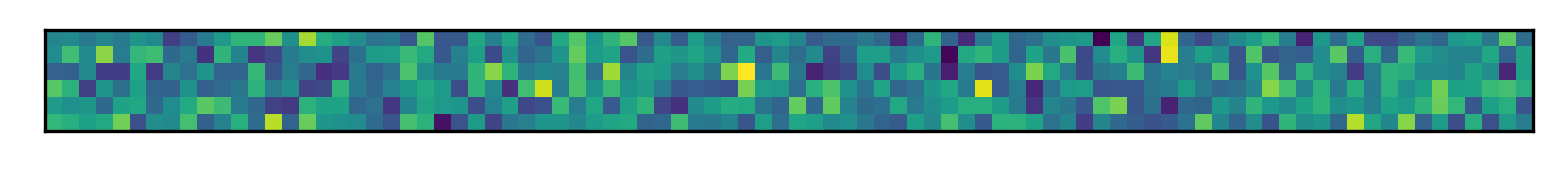

In [52]:
def show_matrix(mat, fname:str=""):
    """Visualize the matrix"""
    fig, ax = plt.subplots(dpi=300)
    ax.imshow(mat.T)
    ax.set(
        xticklabels=[],
        xticks=[],
        yticklabels=[],
        yticks=[],
    )
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

show_matrix(
    noised_angles,
    "../plots/pdb_structures/noising_visualization/fully_noised_values.pdf"
).show()

In [53]:
clean_view, clean_angles = visualize_training_example(
    i=56, timestep=0,
    struct_pdb="../plots/pdb_structures/noising_visualization/clean.pdb",
)
clean_view

NGLWidget()

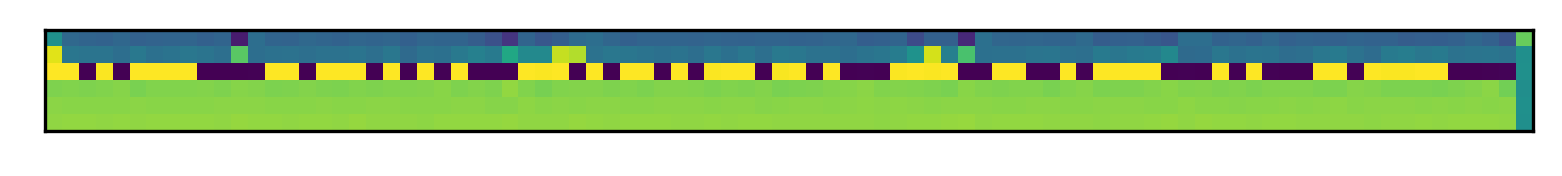

In [54]:
show_matrix(
    clean_angles,
    "../plots/pdb_structures/noising_visualization/clean_values.pdf"
).show()

## Look at reconstruction within training examples

In [13]:
# Look at the full defined set, or 4 angles we currently fit, or 3 dihedrals

angle_sets_to_evaluate = [
    ["phi", "psi", "omega", "tau", "CA:C:1N", "C:1N:1CA"],
    ["phi", "psi", "omega", "tau"], 
    ["phi", "psi", "omega"],
]

# Look at either all the distances or none of them
dist_sets_to_evaluate = [
    ["0C:1N", "N:CA", "CA:C"],
    []
]

# Combinatorially look at these angle sets
def evaluate_angle_set_parallel(filenames, angles, dists):
    warnings.filterwarnings('ignore', '.*elements were guessed from atom_name.*')
    warnings.filterwarnings('ignore', '.*invalid value encountered in true_div.*')
    pfunc = functools.partial(
        test_consistency,
        angles_to_use=angles,
        dists_to_use=dists,
    )
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    tm_scores = np.array([score for score, _view in pool.map(pfunc, filenames, chunksize=20)])
    pool.close()
    pool.join()
    return tm_scores

human_readable_angle_combos = [
    "dihedrals, angles, and distances",
    "dihedrals and angles",
    "dihedrals, tau, and distances",
    "dihedrals, tau",
    "dihedrals, distances",
    "dihedrals only"
]
per_angle_dist_results = {}
for human_name, (a, d) in zip(human_readable_angle_combos, itertools.product(angle_sets_to_evaluate, dist_sets_to_evaluate)):
    print(human_name, a, d)
    per_angle_dist_results[human_name] = evaluate_angle_set_parallel(train_dset.filenames[:10000], angles=a, dists=d)

dihedrals, angles, and distances ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals and angles ['phi', 'psi', 'omega', 'tau', 'CA:C:1N', 'C:1N:1CA'] []


dihedrals, tau, and distances ['phi', 'psi', 'omega', 'tau'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals, tau ['phi', 'psi', 'omega', 'tau'] []


dihedrals, distances ['phi', 'psi', 'omega'] ['0C:1N', 'N:CA', 'CA:C']


dihedrals only ['phi', 'psi', 'omega'] []


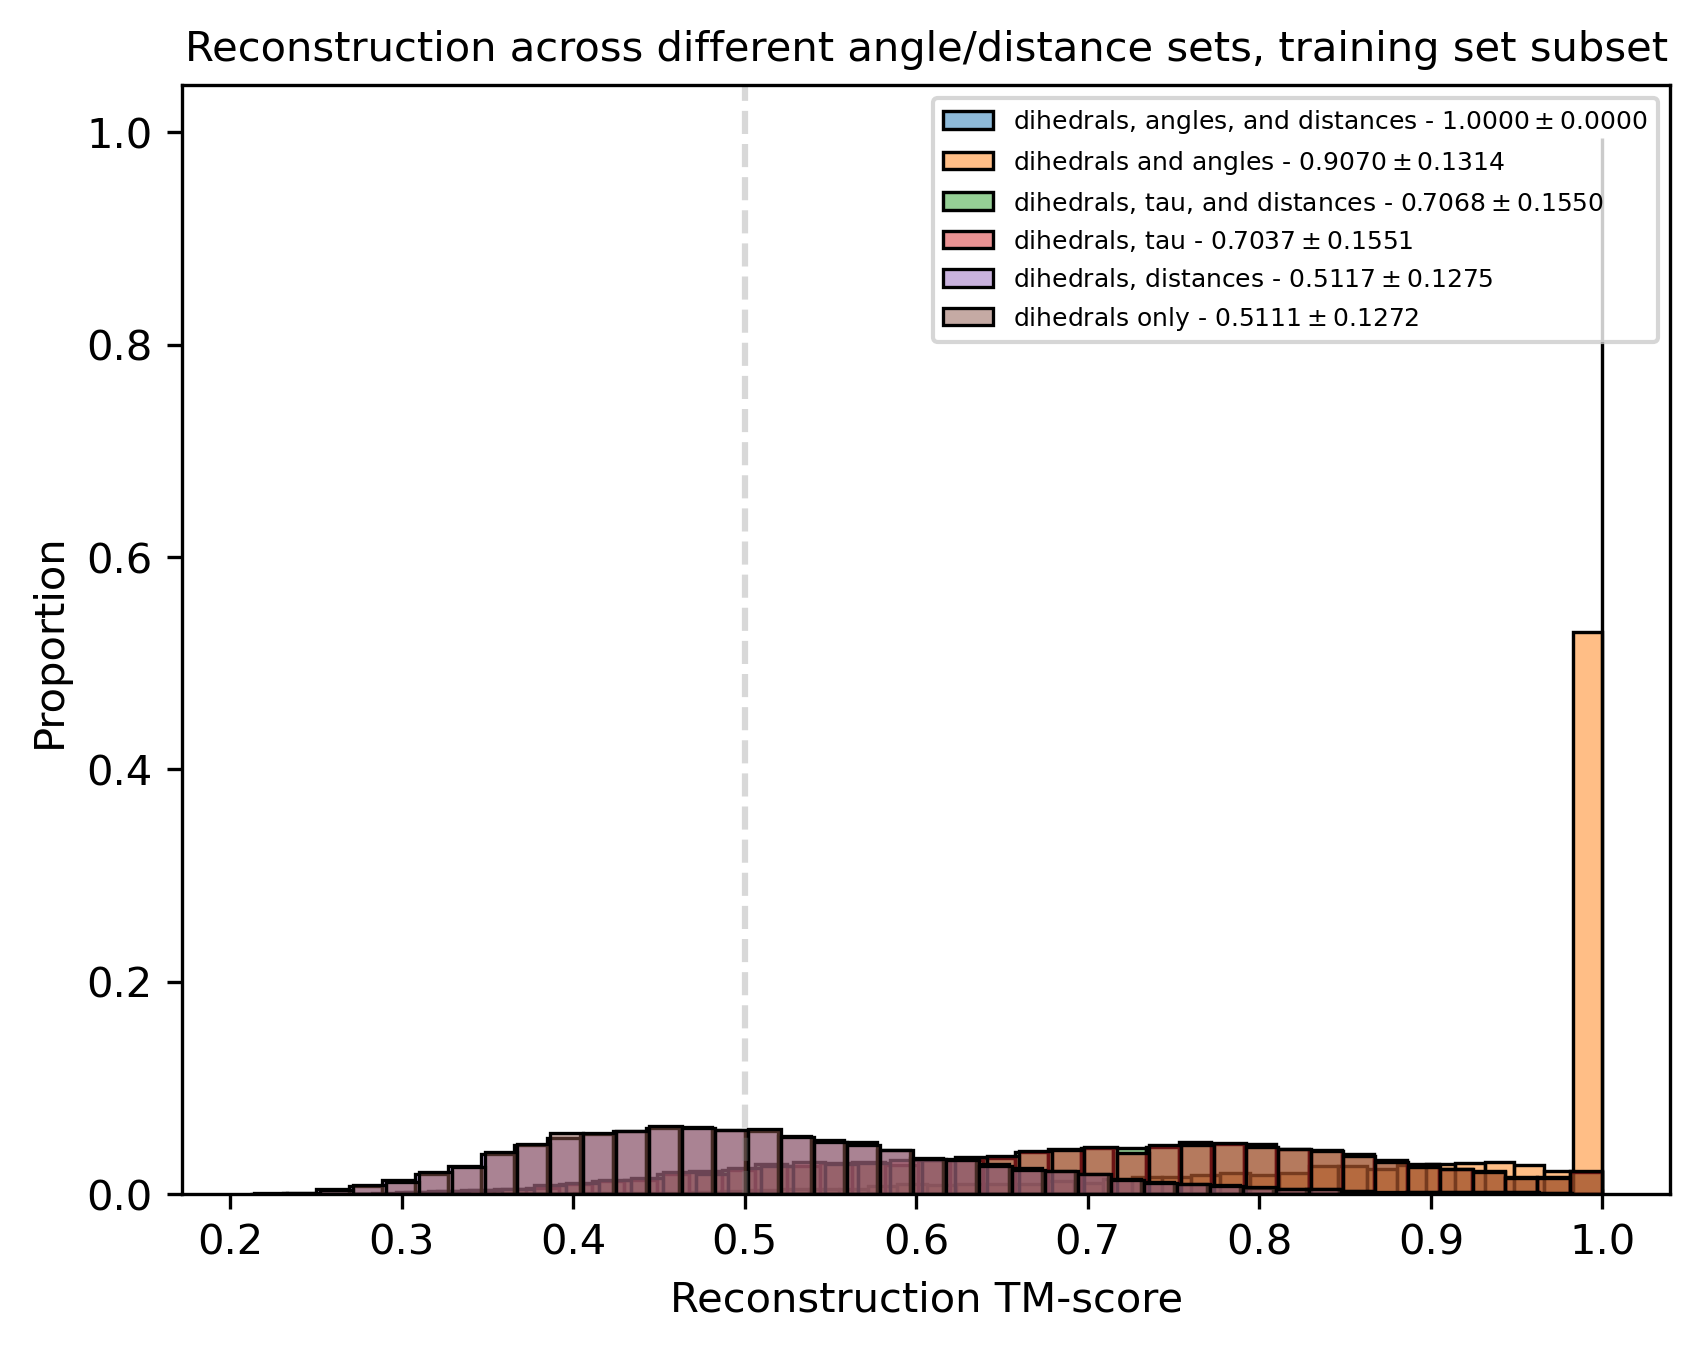

In [14]:
# Plot these results
reconst_tmscore_dir = plotting.PLOT_DIR / "reconstruction_angles_coords"
if not reconst_tmscore_dir.is_dir():
    os.makedirs(reconst_tmscore_dir)

fig, ax = plt.subplots(dpi=300)
for i, (k, v) in enumerate(per_angle_dist_results.items()):
    c = [
        'tab:blue',
        'tab:orange',
        'tab:green',
        'tab:red',
        'tab:purple',
        'tab:brown',
    ][i]
    mean = np.nanmean(v)
    std = np.nanstd(v)
    sns.histplot(v, bins=40, stat='proportion', ax=ax, label=f"{k} - ${mean:.4f} \pm {std:.4f}$", alpha=0.5, color=c)
ax.axvline(0.5, color='grey', alpha=0.3, linestyle='--')
ax.legend(prop={'size': 6})
ax.set(
    xlabel="Reconstruction TM-score",
)
ax.set_title("Reconstruction across different angle/distance sets, training set subset", fontsize=10)
fig.savefig(reconst_tmscore_dir / "reconstruction_distributions.pdf", bbox_inches='tight')
fig.show()

In [15]:
reconstruction_scores = pd.DataFrame(
    per_angle_dist_results
)
reconstruction_scores

,"dihedrals, angles, and distances",dihedrals and angles,"dihedrals, tau, and distances","dihedrals, tau","dihedrals, distances",dihedrals only
0,1.0,0.72122,0.51061,0.52414,0.45682,0.50375
1,1.0,0.99923,0.90519,0.90311,0.68439,0.68659
2,1.0,0.99919,0.91009,0.90500,0.82801,0.82782
3,1.0,0.68469,0.64907,0.65189,0.52648,0.50846
4,1.0,0.63827,0.64059,0.62120,0.50915,0.49763
...,...,...,...,...,...,...
9995,1.0,0.67097,0.64512,0.57580,0.47640,0.45544
9996,1.0,0.99835,0.76813,0.77120,0.49538,0.49819
9997,1.0,0.85338,0.70622,0.69057,0.46990,0.46539
9998,1.0,0.78263,0.51949,0.52889,0.47301,0.45947


In [16]:
np.nanmean(reconstruction_scores, axis=0), np.nanstd(reconstruction_scores, axis=0)

(array([0.99999994, 0.90700298, 0.70680368, 0.70368457, 0.51173542,
        0.51114833]),
 array([8.28666869e-07, 1.31399606e-01, 1.54950650e-01, 1.55108050e-01,
        1.27497169e-01, 1.27212093e-01]))

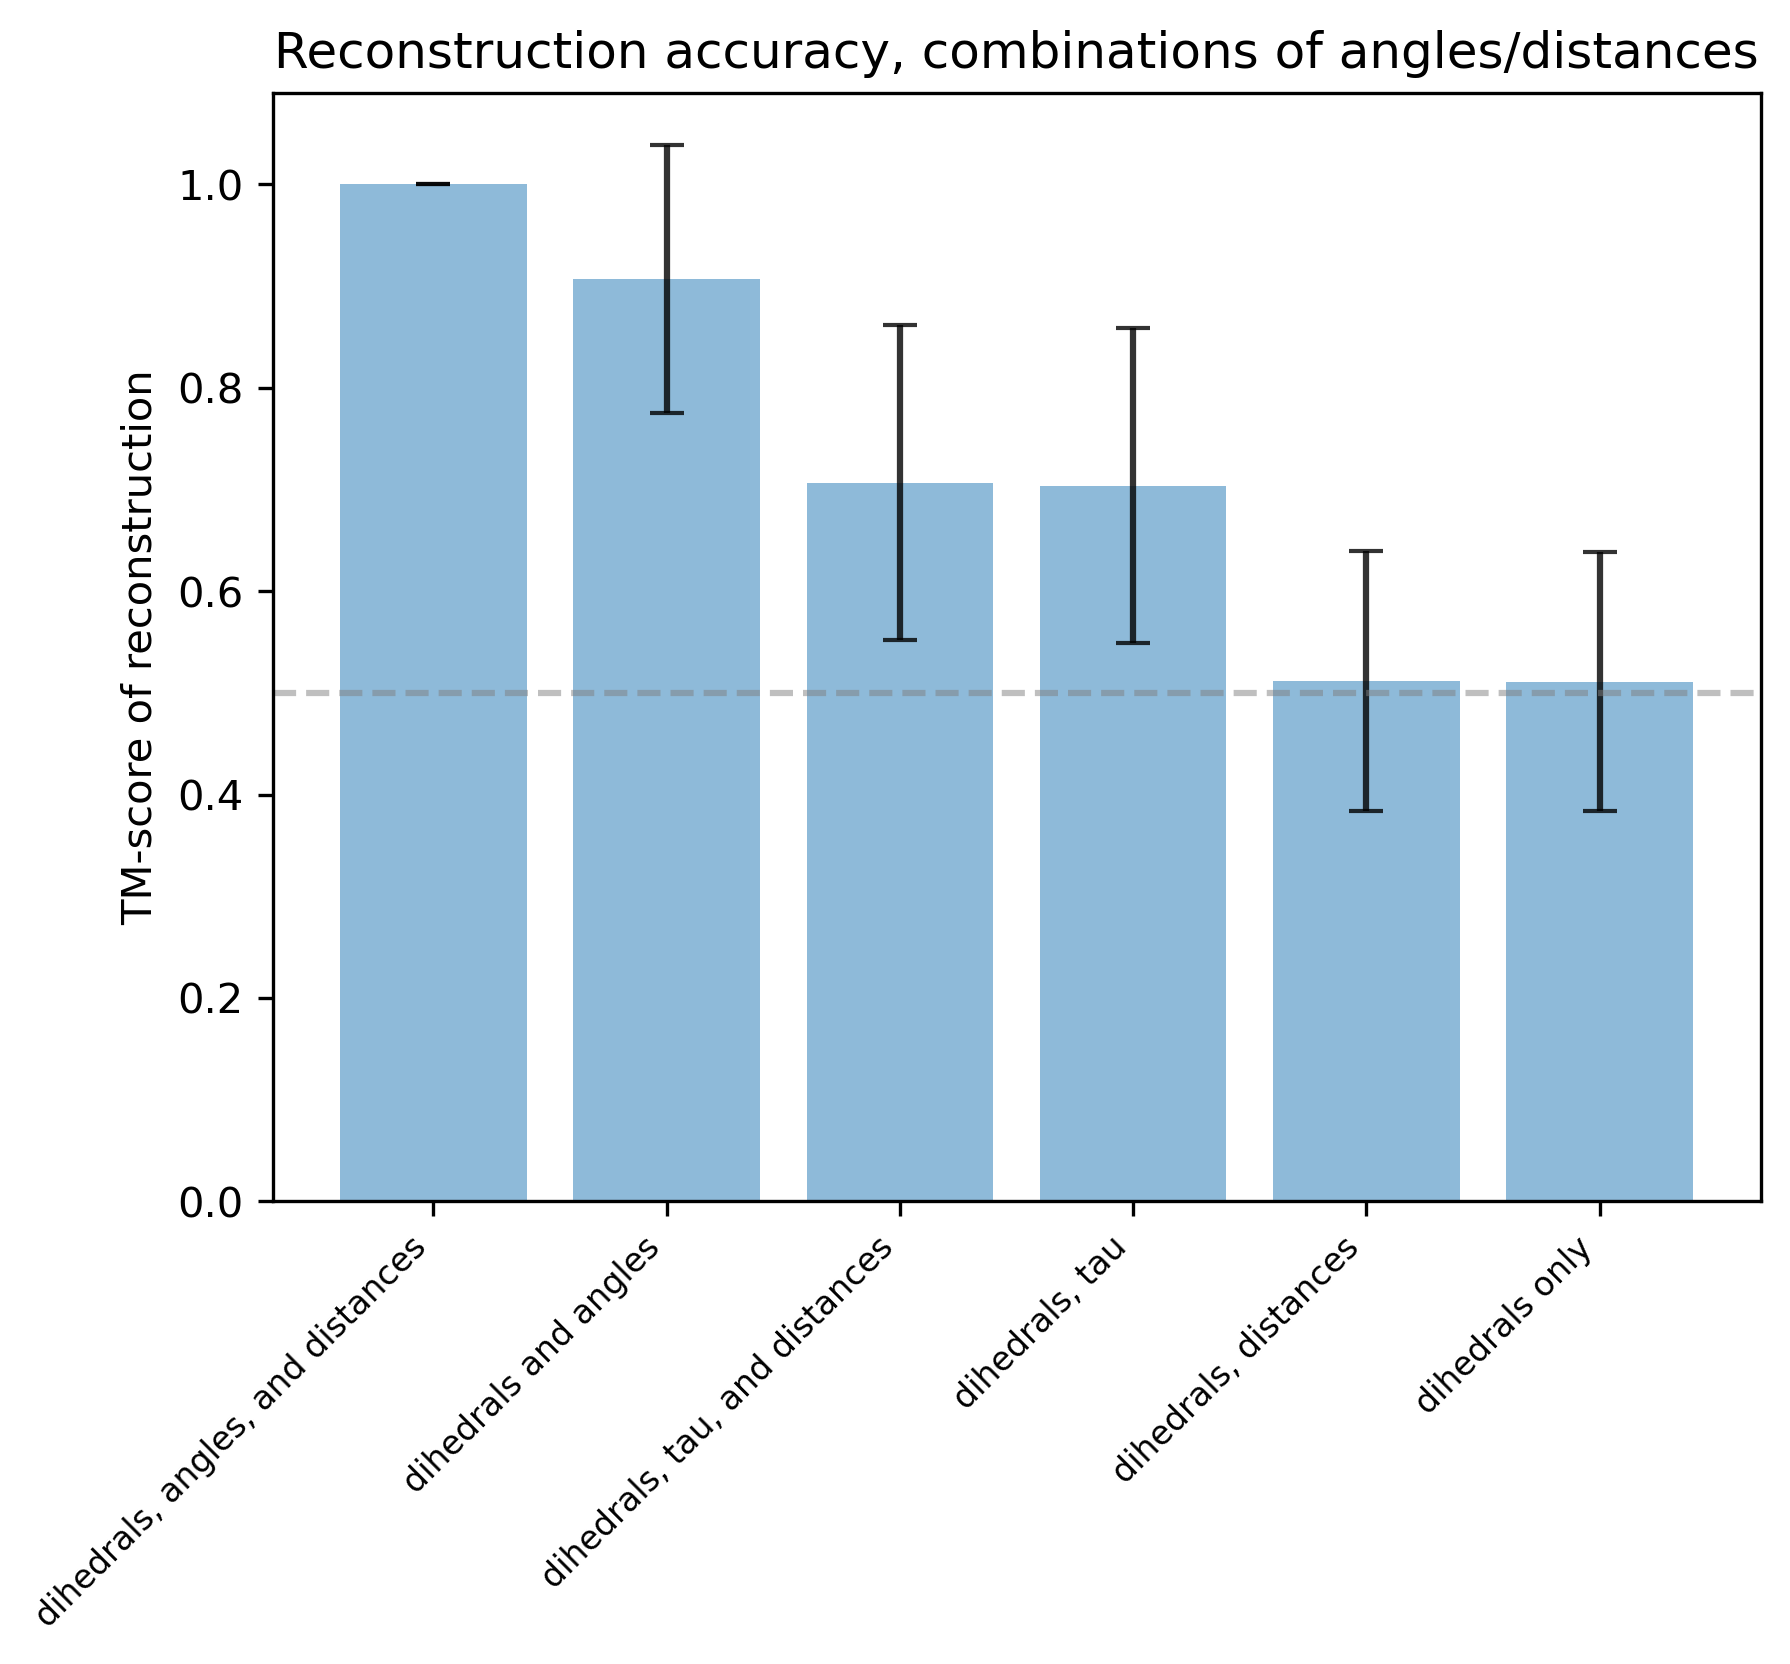

In [17]:
fig, ax = plt.subplots(dpi=300)
ax.bar(
    np.arange(reconstruction_scores.shape[1]),
    np.nanmean(reconstruction_scores, axis=0),
    yerr=np.nanstd(reconstruction_scores, axis=0),
    alpha=0.5,
    error_kw={"capsize": 4.0, "color": 'grey', "alpha": 0.8},
)
ax.set_xticks(list(range(6)))
ax.set_xticklabels(reconstruction_scores.columns, rotation=45, ha='right', size=8)
ax.axhline(0.5, linestyle='--', color='grey', alpha=0.5)
ax.set(
    ylabel="TM-score of reconstruction",
    title="Reconstruction accuracy, combinations of angles/distances",
)
fig.savefig(reconst_tmscore_dir / "reconstruction_barplot.pdf", bbox_inches='tight')
fig.show()